# Neural Symbolic Learner

## Dependencies

In [1]:
!pip install keras-rectified-adam keras.utils tqdm numpy pandas sklearn tensorflow matplotlib warnings

ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


In [2]:
import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneOut
import keras
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras_radam import RAdam
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from keras import backend as K
import tensorflow as tf
import numpy as np
import random
import os
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


## Import Data from CSV

In [33]:
# path to the data
path = 'trains-data.csv'
str_att = {
    'length': ['short', 'long'],
    'shape': ['closedrect', 'dblopnrect', 'ellipse', 'engine', 'hexagon',
              'jaggedtop', 'openrect', 'opentrap', 'slopetop', 'ushaped'],
    'load_shape': ['circlelod', 'hexagonlod', 'rectanglod', 'trianglod'],
    'Class_attribute': ['west', 'east']
}


def read_data(path=path):
    df = pd.read_csv(path, ',')

    for k in df:
        for att in str_att:
            if k.startswith(att):
                for i, val in enumerate(df[k]):
                    if val in str_att[att]:
                        df[k][i] = str_att[att].index(val)

    df.replace("\\0", 0, inplace=True)
    df.replace("None", -1, inplace=True)

    return df


df = read_data()
df


,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,num_loads2,load_shape2,num_wheels3,length3,shape3,num_loads3,load_shape3,num_wheels4,length4,shape4,num_loads4,load_shape4,Rectangle_next_to_rectangle,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,Class_attribute
0,5,4,2,1,6,3,2,2,0,8,1,3,3,1,6,1,1,2,0,6,1,0,0,1,0,0,0,1,0,0,1,0,1
1,4,3,2,0,9,1,3,2,0,7,1,2,2,0,0,2,0,-1,-1,-1,-1,-1,0,1,0,1,0,0,0,0,0,0,1
2,4,2,2,0,6,1,0,2,0,4,1,3,3,1,0,1,3,-1,-1,-1,-1,-1,0,0,0,0,1,0,1,0,0,0,1
3,5,2,2,0,7,1,3,2,0,1,1,3,2,0,2,1,2,2,0,6,1,2,1,1,0,0,1,0,0,0,0,0,1
4,4,3,2,0,1,1,3,3,1,0,1,2,2,0,0,1,0,-1,-1,-1,-1,-1,0,1,0,1,0,0,0,0,0,0,1
5,3,2,2,1,0,3,0,2,0,6,1,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0
6,4,2,2,0,1,1,0,2,0,9,1,3,2,1,5,0,-1,-1,-1,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0
7,3,2,3,1,0,1,2,2,0,9,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,1,0,0,0,0,0,0,0
8,5,2,2,0,7,1,0,2,1,5,1,2,2,0,6,1,2,2,0,7,1,0,1,0,0,1,0,0,0,0,0,0,0
9,3,1,2,0,9,1,2,2,1,6,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,0,0,0,0,0,0,0,0,0


## Question 1.

Implemente uma solução que implemente proposicionalização com 32 neurônios
de entrada e uma única saída (denotando leste).

In [ ]:
# get data
df = read_data()
Y = np.array(df.pop('Class_attribute'))
X = np.array(df)

### Akin Propositionalization Model

In [54]:
# define model
def model_1():
    model = Sequential([
        Dense(9, activation='relu', input_shape=(len(df.keys()),)),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(
        loss=binary_crossentropy,
        optimizer=RAdam(),
        metrics=['mse', 'binary_accuracy']
    )
    return model


es = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=1000, verbose=0)

model = model_1()
model.summary()


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 9)                 297       
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 10        
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


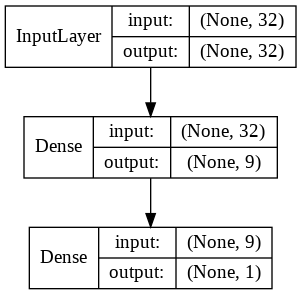

In [56]:
plot_model(model, show_shapes=True, show_layer_names=False)

### Train

In [57]:
# train
leaveOneOut = LeaveOneOut()
hists = dict()
question_1_names = [
    'Train',
    'Output of flat network',
    ' Desired output',
    'Class'
]
question_1 = {name: [] for name in question_1_names}

for i, (train, test) in tqdm.tqdm(enumerate(leaveOneOut.split(X)), total=10):

    x_train = np.asarray(X[train]).astype(np.int)
    y_train = np.asarray(Y[train]).astype(np.int)
    x_test = np.asarray(X[test]).astype(np.int)
    y_test = np.asarray(Y[test]).astype(np.int)

    model = model_1()
    hist = model.fit(
        x_train,
        y_train,
        validation_data=[x_test, y_test],
        epochs=10000,
        verbose=0,
    )
    hists[test[0]] = hist

    question_1['Train'].append(i)
    question_1['Output of flat network'].append(model.predict(x_test)[0][0])
    question_1[' Desired output'].append(y_test[0])
    question_1['Class'].append(str_att['Class_attribute'][int(y_test)])


100%|██████████| 10/10 [03:41<00:00, 22.71s/it]


### Results

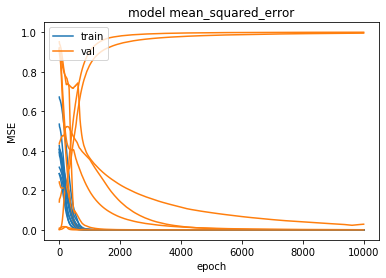

In [61]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['mse'], c='tab:blue')
    plt.plot(history.history['val_mse'], c='tab:orange')

plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


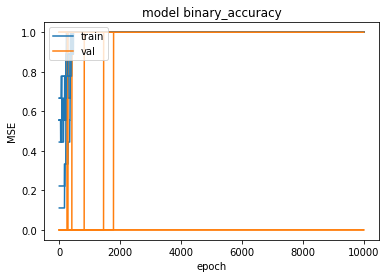

In [62]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['binary_accuracy'], c='tab:blue')
    plt.plot(history.history['val_binary_accuracy'], c='tab:orange')

plt.title('model binary_accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [63]:
train_1 = pd.DataFrame.from_dict(question_1).round(2)
train_1


,Train,Output of flat network,Desired output,Class
0,0,0.00,1,east
1,1,1.00,1,east
2,2,1.00,1,east
3,3,0.83,1,east
4,4,0.99,1,east
5,5,0.00,0,west
6,6,0.03,0,west
7,7,0.00,0,west
8,8,1.00,0,west
9,9,0.00,0,west


## Question 2

Implemente uma solução com base no modelo de aprendizado relacional contendo meta-redes para conectar conceitos das premissas. Este modelos deve conter 11 redes, uma para cada um dos seguintes conceitos conforme definição das páginas 136 e 137:

### metanet

In [46]:
def model_2():
    # features
    t = Input(shape=(1,), name='t')
    c = Input(shape=(1,), name='c')
    w = Input(shape=(1,), name='w')
    l = Input(shape=(1,), name='l')
    s = Input(shape=(1,), name='s')
    nc = Input(shape=(1,), name='nc')
    ls = Input(shape=(1,), name='ls')
    nl = Input(shape=(1,), name='nl')
    ncl = Input(shape=(1,), name='ncl')
    x_crc = Input(shape=(1,), name='x_crc')
    x_hex = Input(shape=(1,), name='x_hex')
    x_rec = Input(shape=(1,), name='x_rec')
    x_tri = Input(shape=(1,), name='x_tri')

    # num_cars(t,nc)
    num_cars_ = concatenate([t, nc])
    num_cars_ = Dense(20, activation='relu')(num_cars_)
    num_cars = Dense(1, activation='sigmoid', name='num_cars')(num_cars_)
    num_cars = Model(inputs=[t, nc], outputs=num_cars)

    # num_loads(t,nl)
    num_loads_ = concatenate([t, nl])
    num_loads_ = Dense(20, activation='relu')(num_loads_)
    num_loads = Dense(1, activation='sigmoid', name='num_loads')(num_loads_)
    num_loads = Model(inputs=[t, nl], outputs=num_loads)

    # num_wheels(t,c,w)
    num_wheels_ = concatenate([t, c, w])
    num_wheels_ = Dense(20, activation='relu')(num_wheels_)
    num_wheels = Dense(1, activation='sigmoid', name='num_wheels')(num_wheels_)
    num_wheels = Model(inputs=[t, c, w], outputs=num_wheels)

    # length(t,c,l)
    length_ = concatenate([t, c, l])
    length_ = Dense(20, activation='relu')(length_)
    length = Dense(1, activation='sigmoid', name='length')(length_)
    length = Model(inputs=[t, c, l], outputs=length)

    # shape(t,c,s)
    shape_ = concatenate([t, c, s])
    shape_ = Dense(20, activation='relu')(shape_)
    shape = Dense(1, activation='sigmoid', name='shape')(shape_)
    shape = Model(inputs=[t, c, s], outputs=shape)

    # num_car_loads(t,c,ncl)
    num_car_loads_ = concatenate([t, c, ncl])
    num_car_loads_ = Dense(20, activation='relu')(num_car_loads_)
    num_car_loads = Dense(1, activation='sigmoid',
                          name='num_car_loads')(num_car_loads_)
    num_car_loads = Model(inputs=[t, c, ncl], outputs=num_car_loads)

    # load_shape(t,c,ls)
    load_shape_ = concatenate([t, c, ls])
    load_shape_ = Dense(20, activation='relu')(load_shape_)
    load_shape = Dense(1, activation='sigmoid', name='load_shape')(load_shape_)
    load_shape = Model(inputs=[t, c, ls], outputs=load_shape)

    # next_crc(t,c,x)
    next_crc_ = concatenate([t, c, x_crc])
    next_crc_ = Dense(20, activation='relu')(next_crc_)
    next_crc = Dense(1, activation='sigmoid', name='next_crc')(next_crc_)
    next_crc = Model(inputs=[t, c, x_crc], outputs=next_crc)

    # next_hex_(t,c,x)
    next_hex_ = concatenate([t, c, x_hex])
    next_hex_ = Dense(20, activation='relu')(next_hex_)
    next_hex = Dense(1, activation='sigmoid', name='next_hex')(next_hex_)
    next_hex = Model(inputs=[t, c, x_hex], outputs=next_hex)

    # next_rec(t,c,x)
    next_rec_ = concatenate([t, c, x_rec])
    next_rec_ = Dense(20, activation='relu')(next_rec_)
    next_rec = Dense(1, activation='sigmoid', name='next_rec')(next_rec_)
    next_rec = Model(inputs=[t, c, x_rec], outputs=next_rec)

    # next_tri(t,c,x)
    next_tri_ = concatenate([t, c, x_tri])
    next_tri_ = Dense(20, activation='relu')(next_tri_)
    next_tri = Dense(1, activation='sigmoid', name='next_tri')(next_tri_)
    next_tri = Model(inputs=[t, c, x_tri], outputs=next_tri)

    # east
    east = concatenate([
        num_cars_,
        num_loads_,
        num_wheels_,
        length_,
        shape_,
        num_car_loads_,
        load_shape_,
        next_crc_,
        next_hex_,
        next_rec_,
        next_tri_
    ])
    east = Dense(3, activation='relu')(east)
    east = Dense(1, activation='sigmoid', name='east')(east)
    east = Model(inputs=[t, c, w, l, s, nc, ls, nl, ncl,
                 x_crc, x_hex, x_rec, x_tri], outputs=east)

    # metanet
    metanet = Model(
        inputs=east.inputs,
        outputs=[
            num_cars.output,
            num_loads.output,
            num_wheels.output,
            length.output,
            shape.output,
            num_car_loads.output,
            load_shape.output,
            next_crc.output,
            next_hex.output,
            next_rec.output,
            next_tri.output,
            east.output
        ])

    # rules
    rules = {
        'num_cars': num_cars,
        'num_loads': num_loads,
        'num_wheels': num_wheels,
        'length': length,
        'shape': shape,
        'num_car_loads': num_car_loads,
        'load_shape': load_shape,
        'next_crc': next_crc,
        'next_hex': next_hex,
        'next_rec': next_rec,
        'next_tri': next_tri,
    }

    return metanet, east, rules


metanet, east, rules = model_2()
metanet.summary()


Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
t (InputLayer)                  (None, 1)            0                                            
__________________________________________________________________________________________________
nc (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
nl (InputLayer)                 (None, 1)            0                                            
__________________________________________________________________________________________________
c (InputLayer)                  (None, 1)            0                                            
___________________________________________________________________________________________

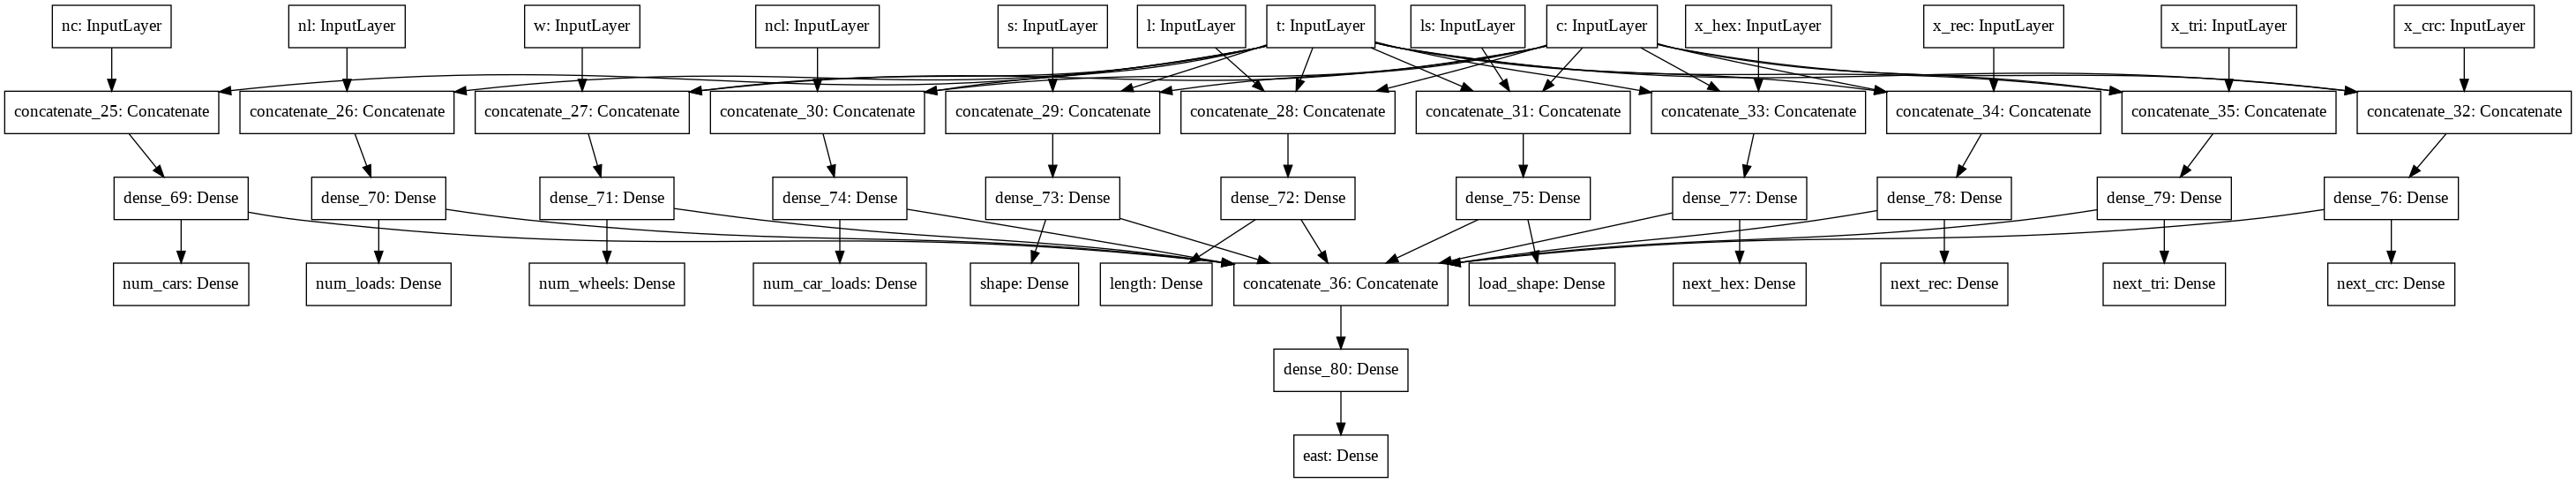

In [49]:
plot_model(metanet, show_shapes=False, show_layer_names=True)

### Data Augmentation

In [ ]:
df = read_data()
cols = [[c for c in df.columns if not (str.isdigit(
    c[-1])) or (str.isdigit(c[-1]) and int(c[-1]) == n)] for n in range(1, 5)]

data = [df[col] for col in cols]
for c, df in enumerate(data):
    df.columns = [name if not str.isdigit(
        name[-1]) else name[:-1] for name in df.columns]
    df['car'] = c+1

data = pd.concat(data)
data.reset_index(level=0, inplace=True)
data['train'] = data.pop('index')
data.T[0]


Number_of_cars                 5
Number_of_different_loads      4
num_wheels                     2
length                         1
shape                          6
num_loads                      3
load_shape                     2
Rectangle_next_to_rectangle    0
Rectangle_next_to_triangle     1
Rectangle_next_to_hexagon      0
Rectangle_next_to_circle       0
Triangle_next_to_triangle      0
Triangle_next_to_hexagon       1
Triangle_next_to_circle        0
Hexagon_next_to_hexagon        0
Hexagon_next_to_circle         1
Circle_next_to_circle          0
Class_attribute                1
car                            1
train                          0
Name: 0, dtype: object

### Train

In [ ]:
def sort_inputs(X):
    t = X['train'].T
    c = X['car'].T
    w = X['num_wheels'].T
    l = X['length'].T
    s = X['shape'].T
    nc = X['Number_of_cars'].T
    ls = X['load_shape'].T
    nl = X['Number_of_different_loads'].T
    ncl = X['num_loads'].T
    x_crc = np.sum(X[[col for col in X if col.endswith('circle')]], axis=1).T
    x_hex = np.sum(X[[col for col in X if col.endswith('hexagon')]], axis=1).T
    x_rec = np.sum(
        X[[col for col in X if col.endswith('rectangle')]], axis=1).T
    x_tri = np.sum(X[[col for col in X if col.endswith('triangle')]], axis=1).T

    return [t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri]


def split(data, val_train):
    x_train = data.query(f'train != {val_train}')
    x_test = data.query(f'train == {val_train}')
    y_train = np.array(x_train.pop('Class_attribute'))
    y_test = np.array(x_test.pop('Class_attribute'))
    x_train = sort_inputs(x_train)
    x_test = sort_inputs(x_test)

    return x_train, x_test, y_train, y_test


In [ ]:
hists = dict()
question_2_names = [
    'Train',
    'Cars Accuracy',
    'Output of flat network',
    'Desired output',
    'Class'
]
question_2 = {name: [] for name in question_2_names}

for validation_i in tqdm.tqdm(range(0, 10)):
    x_train, x_test, y_train, y_test = split(data, validation_i)
    metanet, east, rules = model_2()

    x_train = np.asarray(x_train).astype(np.int)
    y_train = np.asarray(y_train).astype(np.int)
    x_test = np.asarray(x_test).astype(np.int)
    y_test = np.asarray(y_test).astype(np.int)
    y_train2 = y_train.reshape(36, 1)
    print(f'after - y_train2 -> {len(y_train)}, {y_train}')

#   print(x_train)

    east.compile(
        loss=binary_crossentropy,
        optimizer=RAdam(),
        metrics=['mse', 'binary_accuracy'])
    hist = east.fit(
        x_train,
        y_train2,
        validation_data=[x_test, y_test],
        epochs=1000,
        verbose=0,)
    hists[validation_i] = hist

    question_2['Train'].append(validation_i)
    question_2['Output of flat network'].append(east.predict(x_test)[0][0])
    question_2['Desired output'].append(y_test[0])
    question_2['Class'].append(str_att['Class_attribute'][int(y_test[0])])


100%|██████████| 10/10 [03:01<00:00, 20.08s/it]


### Results

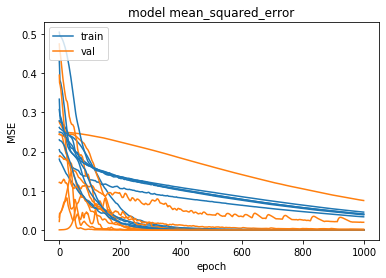

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['mse'], c='tab:blue')
    plt.plot(history.history['val_mse'], c='tab:orange')

plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


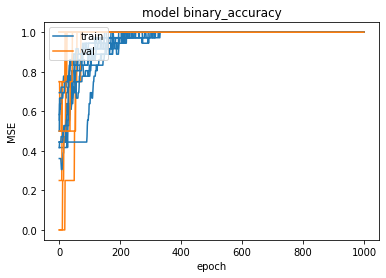

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['binary_accuracy'], c='tab:blue')
    plt.plot(history.history['val_binary_accuracy'], c='tab:orange')

plt.title('model binary_accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
t2 = pd.DataFrame.from_dict(question_2).round(2)
t2['Cars Accuracy'] = [hists[i].history['binary_accuracy'][-1]
                       for i in range(0, 10)]
t2 = t2.reindex(columns=['Train', 'Cars Accuracy',
                'Output of flat network', 'Desired output', 'Class'])
t2


,Train,Cars Accuracy,Output of flat network,Desired output,Class
0,0,1.0,0.73,1,east
1,1,1.0,1.00,1,east
2,2,1.0,0.99,1,east
3,3,1.0,1.00,1,east
4,4,1.0,0.74,1,east
5,5,1.0,0.01,0,west
6,6,1.0,0.00,0,west
7,7,1.0,0.00,0,west
8,8,1.0,0.00,0,west
9,9,1.0,0.00,0,west
